In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid", {"grid.color": ".6",
                           "grid.linestyle": ":"})

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
dataset=pd.read_csv("gold_price_data.csv",parse_dates=["Date"])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   SPX      2290 non-null   float64       
 2   GLD      2290 non-null   float64       
 3   USO      2290 non-null   float64       
 4   SLV      2290 non-null   float64       
 5   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 107.5 KB


In [3]:
"""
| Column      | Meaning                        | Description                                                                                                                                                              |
| :---------- | :----------------------------- | :----------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Date**    | Date of observation            | The timestamp for each record — for example, daily or weekly data. All other features correspond to this date.                                                           |
| **SPX**     | S&P 500 Index                  | Represents the U.S. **stock market index** tracking the performance of 500 major companies. Used as a proxy for market performance and investor sentiment.               |
| **GLD**     | SPDR Gold Shares ETF           | Tracks the price of **gold**. Often used as a hedge against inflation or stock market downturns.                                                                         |
| **USO**     | United States Oil Fund         | Tracks the price of **crude oil**. Reflects energy market conditions and global demand trends.                                                                           |
| **SLV**     | iShares Silver Trust           | Tracks the price of **silver**. Like gold, it’s a precious metal investment, but also used in industry.                                                                  |
| **EUR/USD** | Euro–U.S. Dollar Exchange Rate | Represents the **foreign exchange rate** between the Euro and U.S. Dollar. Indicates relative currency strength and can affect international trade and commodity prices. |

"""

'\n| Column      | Meaning                        | Description                                                                                                                                                              |\n| :---------- | :----------------------------- | :----------------------------------------------------------------------------------------------------------------------------------------------------------------------- |\n| **Date**    | Date of observation            | The timestamp for each record — for example, daily or weekly data. All other features correspond to this date.                                                           |\n| **SPX**     | S&P 500 Index                  | Represents the U.S. **stock market index** tracking the performance of 500 major companies. Used as a proxy for market performance and investor sentiment.               |\n| **GLD**     | SPDR Gold Shares ETF           | Tracks the price of **gold**. Often used as a hedge against infl

In [4]:
# Missing Values/Null Values Count
dataset.isna().sum()

,0
Date,0
SPX,0
GLD,0
USO,0
SLV,0
EUR/USD,0


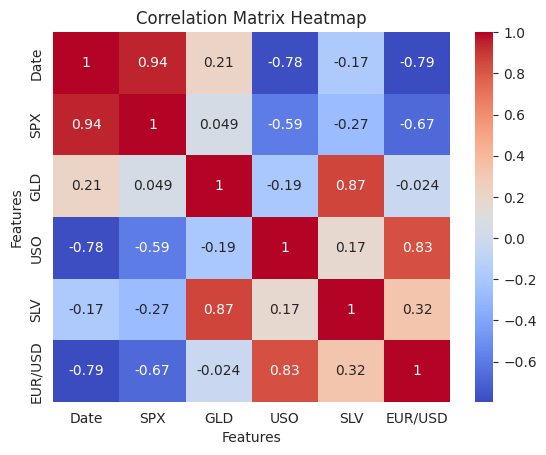

In [5]:
# Calculate correlation matrix
correlation  = dataset.corr()
# print(correlation)

sns.heatmap(correlation, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [6]:
#both in your model does not add new information — it just repeats what’s already there
# drop SlV column
dataset.drop("SLV", axis=1,inplace=True)

In [7]:
# reset the index to date column
dataset.set_index("Date", inplace=True)

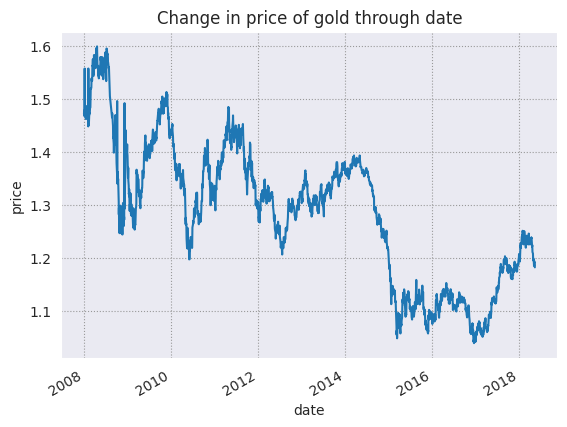

In [8]:
# plot price of gold for each increasing day
dataset["EUR/USD"].plot()
plt.title("Change in price of gold through date")
plt.xlabel("date")
plt.ylabel("price")
plt.show()

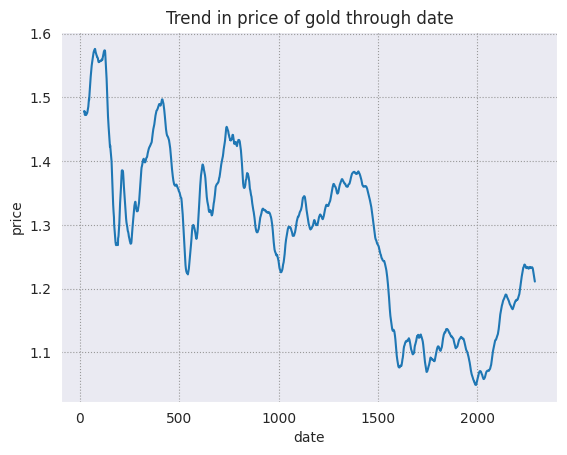

In [9]:
# apply rolling mean with window size of 3
dataset["price_trend"] = dataset["EUR/USD"]\
    .rolling(window=20).mean()

# reset the index to date column
dataset.reset_index("Date", inplace=True)

# since we have used rolling method
# for 20 rows first 2 rows will be NAN
dataset["price_trend"].loc[20:].plot()

# set title of the chart
plt.title("Trend in price of gold through date")

# set x_label of the plot
plt.xlabel("date")
plt.ylabel("price")
plt.show()

In [10]:
dataset.head(5)

,Date,SPX,GLD,USO,EUR/USD,price_trend
0,2008-01-02,1447.160034,84.860001,78.470001,1.471692,NaN
1,2008-01-03,1447.160034,85.570000,78.370003,1.474491,NaN
2,2008-01-04,1411.630005,85.129997,77.309998,1.475492,NaN
3,2008-01-07,1416.180054,84.769997,75.500000,1.468299,NaN
4,2008-01-08,1390.189941,86.779999,76.059998,1.557099,NaN


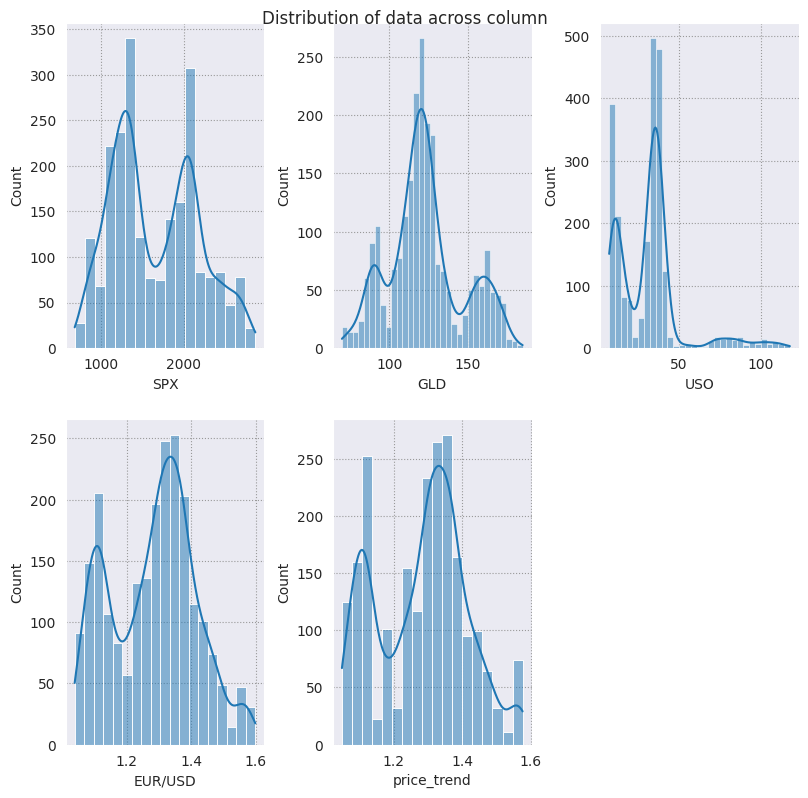

In [11]:
#Distribution  of Columns
fig = plt.figure(figsize=(8, 8))

# suptitle of the graph
fig.suptitle('Distribution of data across column')
temp = dataset.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=dataset, x=item, kde=True)
plt.tight_layout(pad=0.4, w_pad=0.7, h_pad=2.0)
plt.show()

In [12]:
# skewness along the index axis
print(dataset.drop("Date", axis=1).skew(axis=0, skipna=True))



SPX            0.300362
GLD            0.334138
USO            1.699331
EUR/USD       -0.005292
price_trend   -0.029588
dtype: float64


In [13]:
# apply saquare root transformation on the skewed dataset
dataset["USO"] = dataset["USO"]\
    .apply(lambda x: np.sqrt(x))

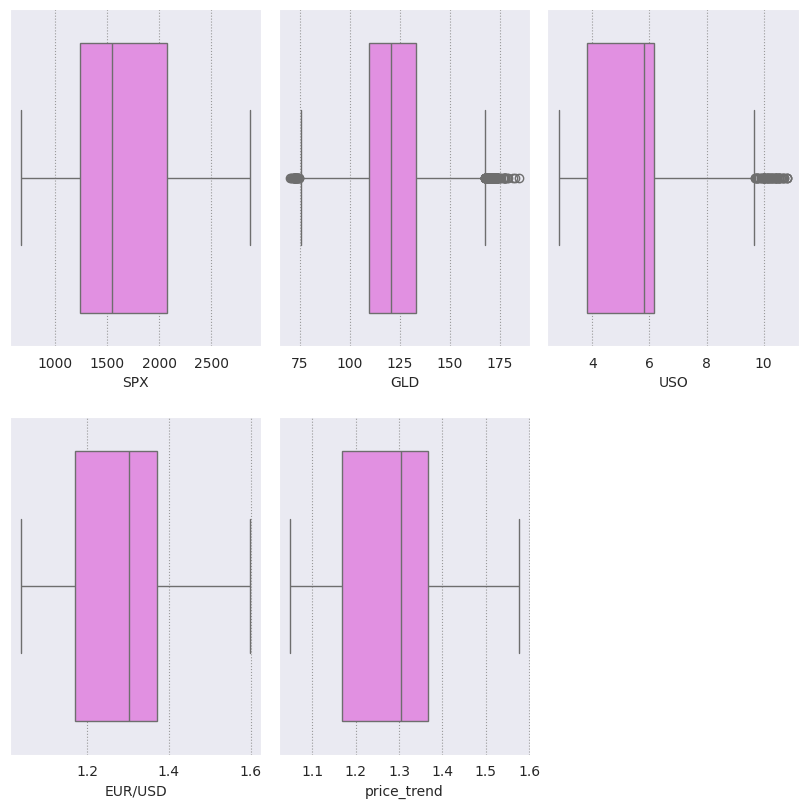

In [14]:
#Plotting Boxplot to Visualize the Outliers
fig = plt.figure(figsize=(8, 8))
temp = dataset.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=dataset, x=item, color='violet')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

In [15]:
def outlier_removal(column):
    # set upper limit to 95percentile
    upper_limit = column.quantile(.95)
    # set lower limit to 5 percentile
    lower_limit = column.quantile(.05)

    column.loc[(column > upper_limit)] = upper_limit
    column.loc[(column < lower_limit)] = lower_limit
    return column

In [16]:
# Normalize outliers in columns except Date

dataset[['SPX', 'GLD', 'USO', 'EUR/USD']] = \
    dataset[['SPX', 'GLD', 'USO', 'EUR/USD']].apply(outlier_removal)

In [17]:
# select the features and target variable
X = dataset.drop(['Date', 'GLD'], axis=1)

y = dataset['GLD']
# dividing dataset in to train test
x_train, x_test,\
    y_train, y_test = train_test_split(X, y,
                                       test_size=0.2)

In [18]:

scaler = StandardScaler()

# Fit the StandardScaler on the training dataset
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [28]:

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') # Replace NaNs with the mean of each column
x_train_scaled = imputer.fit_transform(x_train_scaled)
x_test_scaled = imputer.transform(x_test_scaled)

# Create a PolynomialFeatures object of degree 3
poly = PolynomialFeatures(degree=3)

lasso = Lasso()

# Define a dictionary of parameter
#values to search over
param_grid = {'lasso__alpha': [1e-4, 1e-3, 1e-2,
							1e-1, 1, 5, 10,
							20, 30, 40]}

# Create a pipeline that first applies
# polynomial features and then applies Lasso regression
pipeline = make_pipeline(poly, lasso)

# Create a GridSearchCV object with
#the pipeline and parameter grid
lasso_grid_search = GridSearchCV(pipeline,
								param_grid,
								scoring='r2', cv=3)

# Fit the GridSearchCV object to the training data
lasso_grid_search.fit(x_train_scaled, y_train)

# Predict the target variable using
# the fitted model and the test data
y_pred = lasso_grid_search.predict(x_train_scaled)

# Compute the R-squared of the fitted model on the train data
r2 = r2_score(y_train, y_pred)

# Print the R-squared
print("R-squared: ", r2)

# Print the best parameter values and score
print('Best parameter values: ',
	lasso_grid_search.best_params_)
print('Best score: ',
	lasso_grid_search.best_score_)

R-squared:  0.8132137976458012
Best parameter values:  {'lasso__alpha': 0.001}
Best score:  0.8043569437128456


In [30]:
# Insiate param grid for which to search
param_grid = {'n_estimators': [50, 80, 100],
              'max_depth': [3, 5, 7]}

# create instance of the Randomforest regressor
rf = RandomForestRegressor()

# Define Girdsearch with random forest
# object parameter grid scoring and cv
rf_grid_search = GridSearchCV(rf, param_grid, scoring='r2', cv=2)

# Fit the GridSearchCV object to the training data

rf_grid_search.fit(x_train_scaled, y_train)

# Print the best parameter values and score
print('Best parameter values: ', rf_grid_search.best_params_)
print('Best score: ', rf_grid_search.best_score_)

Best parameter values:  {'max_depth': 7, 'n_estimators': 100}
Best score:  0.935319440297282


In [31]:
# Compute the R-squared of the
# fitted model on the test data
r2 = r2_score(y_test,
              rf_grid_search.predict(x_test_scaled))

# Print the R-squared
print("R-squared:", r2)

R-squared: 0.9359487328245751


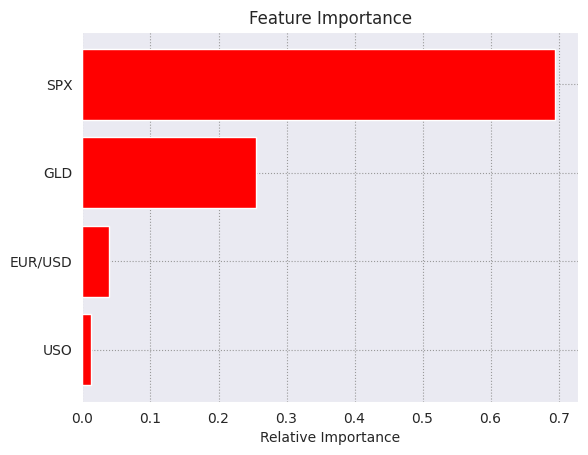

In [32]:
features = dataset.drop("Date", axis=1).columns

# store the importance of the feature
importances = rf_grid_search.best_estimator_.\
    feature_importances_


indices = np.argsort(importances)

# title of the graph
plt.title('Feature Importance')

plt.barh(range(len(indices)),
         importances[indices],
         color='red',
         align='center')

# plot bar chart
plt.yticks(range(len(indices)),
           [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [33]:
# Create an instance of the XGBRegressor model
model_xgb = XGBRegressor()

# Fit the model to the training data
model_xgb.fit(x_train_scaled, y_train)

# Print the R-squared score on the training data
print("Xgboost Accuracy =", r2_score(
    y_train, model_xgb.predict(x_train_scaled)))

Xgboost Accuracy = 0.9992126249728785


In [34]:
# Print the R-squared score on the test data
print("Xgboost Accuracy on test data =",
      r2_score(y_test,
               model_xgb.predict(x_test_scaled)))

Xgboost Accuracy on test data = 0.9674689243857888


In [ ]:
#Model deploy
# dump model using pickle library
import pickle

# dump model in file model.pkl
pickle.dump(model_xgb, open('model.pkl', 'wb'))